# Table of Contents
1. [Introduction](#1)
1. [Data Preprocessing](#2)
1. [Exploratory Data Analysis](#3)
1. [Elastic Net Regression](#4)
    1. [Training The Regression Model](#5)
    1. [Results](#6)
1. [Time Series Decomposition](#7)
    1. [Training The Decomposition Model](#8)
    1. [Results](#9)
1. [Regression vs Decomposition Results](#10)
1. [KNN Classification](#11)
    1. [Training The Classification Model](#12)
    1. [Results](#13)
1. [Conclusion](#14)
1. [References](#15)

# Introduction
<a id="1"></a>

In this project, our group of analysts aims to utilise supervised machine-learning methods to optimise a model that predicts COE prices. We use __Regression__ and __Time-Series__ modeling to analyse the numerical trend of the prices, while implementing a __Classification__ model to predict the future class groups of this trend. The objective of this analysis is to train each model to find the best hyperparameters for modeling, and select the best models for predictive analytics. 

To provide context, COE (Certificate of Entitlement) is a quota license for owning a vehicle in Singapore, and is usually bidded bi-monthly across 5 major categories of vehicles. The prices of which are usually affected by supply and demand or known as Quota and Bids per round, and have been steadily increasing over time. In particular, we consider only fleets comprising cars with engine capacities not exceeding 1600cc and maximum power output no more than 97kW in this analysis, hence the Category A of the COE tiers. 

View [here](https://onemotoring.lta.gov.sg/content/onemotoring/home/buying/upfront-vehicle-costs/certificate-of-entitlement--coe-.html) to learn more about how COE works. 



# Data Preprocessing
<a id="2"></a>

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import log, ceil, floor
from itertools import compress
from scipy.optimize import minimize
from scipy.stats import iqr, norm
from sklearn.linear_model import ElasticNet
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFECV
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

def header(text):
    print(f'\033[94m\033[1m{text}\033[0m')
    
def set_figsize(width=6.4, height=4.8):
    plt.rcParams['figure.figsize'] = width, height

# import data from local environment:
def get_dir(filename):
    dirs = glob.glob(os.path.join(os.getcwd(), "", "") + "/*")
    files = {os.path.basename(f): f for f in dirs}
    fpath = files[filename]
    return fpath

df = pd.read_csv(get_dir('COE.csv'), index_col='Date')


The historical data used here is _COE.csv_ which contains bi-monthly bidding entries across all categories and their respective bids-to-quota information from 2002-03-15 to 2023-03-15. We processed the data by:

> - importing the data and utilising the _Date feature as the dataset index;
> - converting any boolean features to $1$ and $0$;
> - selecting only numerical features;
> - excluding features with only 1 unique factor;
> - interpolating missing values with existing observations;
> - removing data that cannot be interpolated at the bottom of the dataset

The resulting data is $500 \times 12$ matrix with 500 observations and 12 features. We use this dataset for the Time-Series analysis because the frequency of observations (i.e the prediocity) must be sequentially consistent and in this case would be bi-monthly, hence we cannot tamper with the data such as shuffling or removing observations between the first and last rows. We save a copy of this dataset for the Time-Series model labeled as __df_ts__.


In [2]:
df[df.columns[df.dtypes == 'bool']] += 0 #convert any True/False column to 1/0
df = df \
    .select_dtypes(include='number') \
    .replace([float('inf'), float('-inf'), None, 'NULL', 'Null', 'null'], float('nan')) \
    .interpolate(limit_area='inside') \
    .dropna(axis=0, how='all') \
    .dropna(axis=1)

df = df[df.columns[df.nunique() > 1]] # delete any column of same value

df.index = pd.DatetimeIndex(df.index, freq='SMS-15') # set freq of datetime index

df_ts = df.copy() # copy df for time series model

display(df)

,CatACOE,CatAQuota,CatABids,CatBCOE,CatBQuota,CatBBids,CatECOE,CatEQuota,CatEBids,A_bids/Quota,B_bids/Quota,E_bids/Quota
Date,,,,,,,,,,,,
2002-03-15,33201.0,1468.0,2800.0,34200.0,651.0,1052.0,34501.0,817.0,1594.0,1.907357,1.615975,1.951040
2002-04-01,37201.0,1110.0,2484.0,39509.0,558.0,1119.0,41001.0,682.0,1797.0,2.237838,2.005376,2.634897
2002-04-15,36000.0,1149.0,1890.0,42101.0,553.0,1104.0,42043.0,754.0,1407.0,1.644909,1.996383,1.866048
2002-05-01,35000.0,1128.0,1705.0,40001.0,560.0,1043.0,40001.0,960.0,1880.0,1.511525,1.862500,1.958333
2002-05-15,33401.0,1111.0,1320.0,38001.0,552.0,894.0,38399.0,910.0,1835.0,1.188119,1.619565,2.016484
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,87235.0,460.0,687.0,115388.0,411.0,640.0,116577.0,146.0,283.0,1.493478,1.557178,1.938356
2022-11-15,90589.0,459.0,622.0,113881.0,416.0,568.0,114009.0,150.0,242.0,1.355120,1.365385,1.613333
2022-12-01,88503.0,458.0,616.0,105501.0,427.0,568.0,110524.0,149.0,266.0,1.344978,1.330211,1.785235


To create the datasets for the Regression and Classification models, we use 3 layers of outlier detection methods to find the common outlier(s), and then removed them from our data. The resulting dataset is a $499 \times 12$ matrix with 500 observations and 12 features.

In [3]:
def find_outliers(df):
    #Isolation Forest

    from sklearn.ensemble import IsolationForest
    #-1 in 'g' identifies an outlier position:
    g = IsolationForest(n_jobs=-1, random_state=None).fit_predict(df).tolist()
    print('\nNumber of IsolationForest outliers:', g.count(-1))

    #Local Outlier Factor

    from sklearn.neighbors import LocalOutlierFactor
    a0 = LocalOutlierFactor(n_jobs=-1)
    #-1 in 'a' identifies an outlier position:
    a = a0.fit_predict(df).tolist()
    ac = a.count(-1) #keep for EllipticEnvelope
    an = a0.negative_outlier_factor_ #use this size info to rank outliers later
    print('\nNumber of LocalOutlierFactor outliers:', ac)

    #Elliptic Envelope for Gaussian distribution

    from sklearn.covariance import EllipticEnvelope
    r = len(df)
    #-1 in 'e' identifies an outlier position:
    e = EllipticEnvelope(contamination=min(0.1, ac/r), random_state=None).fit_predict(df).tolist()
    print('\nNumber of EllipticEnvelope outliers:', e.count(-1))

    #find shared outliers

    if 'b' in vars():
        f = [-1 if s==-1 and t==-1 and u==-1 and v==-1 else 1 for s, t, u, v in zip(a, b, g, e)]
        del b
    else:
        f = [-1 if s==-1 and t==-1 and u==-1 else 1 for s, t, u in zip(a, g, e)]
    p = f.count(-1)
    q = []
    if p > 0:
        q = [i for i, z in enumerate(f) if z == -1] #indices of outliers
        q = [z for _, z in sorted(zip(an[q], q))][:100] #indices of sorted worst outliers
        print('\nNumber of outliers common to all lists:', p,
              '\nIndices of up to 100 sorted outliers with the worst first:', q,
              'from [0 to', str(r - 1) + '].\n')
        print('\nProportion of data outlying:', '%.5f' % (p / r))
    else:
        print('\nNo outlier common to all lists.\n')
    
    return q


outliers = find_outliers(df)
# remove outliers
for outlier in outliers:
    print(f'\nDropped outlier:{df.iloc[outlier].name} (row {outlier})')
    df.drop(index=df.iloc[outlier].name, inplace=True)

header('\nFinal Dataset Shape:')
print(df.shape)
df_class = df.copy() # copy df for classification model


Number of IsolationForest outliers: 80

Number of LocalOutlierFactor outliers: 12

Number of EllipticEnvelope outliers: 12

Number of outliers common to all lists: 1 
Indices of up to 100 sorted outliers with the worst first: [263] from [0 to 499].


Proportion of data outlying: 0.00200

Dropped outlier:2013-03-01 00:00:00 (row 263)

Final Dataset Shape:
(499, 12)


# Exploratory Data Analysis
<a id='3'/>

In this section, we begin some EDA by mapping out a correlation heatmap to study the relationship between features. The mathematical form of the heatmap can be defined as the matrix:

$$
\begin{bmatrix}
\rho(x_1, x_1) & \rho(x_1, x_2) & \cdots & \rho(x_1, x_k) \\
\rho(x_2, x_1) & \rho(x_2, x_2) & \cdots & \rho(x_1, x_1) \\
\vdots & \vdots & \ddots & \vdots \\
\rho(x_k, x_1) & \rho(x_k, x_2) & \cdots & \rho(x_k, x_k)
\end{bmatrix} \
$$

where $\rho =$ Pearson's correlation and $k =$ the number of features in the dataset.

We define `CatACOE` as our target feature, and found that it is perfectly positively correlated with `CatBCOE` and `CatECOE`, which gives reasonable prior assumption that these may be statistically significant features with respect to `CatACOE`. This will be explored further in our Regression analysis below.

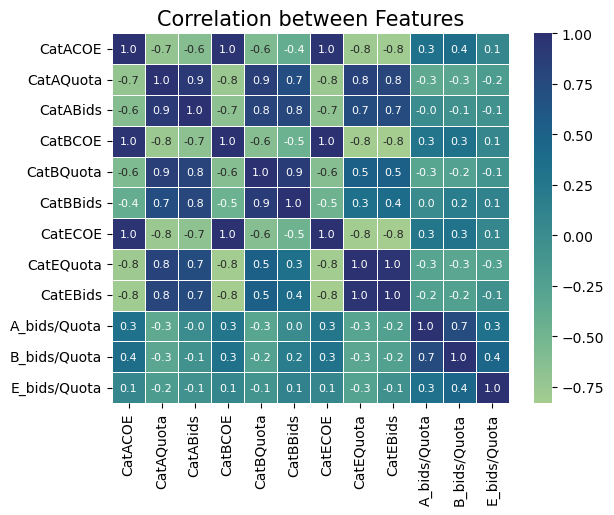

In [4]:
set_figsize()
sns.heatmap(df.corr().round(2), 
            annot=True, fmt= '.1f', 
            linewidth=0.5, cmap='crest',
            annot_kws={"fontsize":8})
plt.title('Correlation between Features', size=15)
plt.show()

# Elastic Net Regression
<a id='4'/>

The Elastic Net regression technique is a regularised linear regression model that aims to estimate the best beta parameters for the data while imposing a penalty threshold against high complexity and thus handles the issue of overfitting. The algorithm is given by:

$$
    argmin_\beta({\sum_i^n}{(y_i - \beta{x_i})^2} + \lambda_1{\sum_{k=1}^K}{|\beta_k|} + \lambda_2{\sum_{k=1}^K}{\beta_k^2})
$$

The Lasso and Ridge constraint functions are also given by:

$$\lambda_1{\sum_{k=1}^K}{|\beta_k|} {\leq} c$$
$$\lambda_2{\sum_{k=1}^K}{\beta_k^2} {\leq} c$$

 In a more high-dimensional space, the Lasso (diamond-shaped constraint function) would have increasing number of vertices. For the $L_1$ model, this means it is highly likely that some coefficients may be reduced to 0 resulting in their features being completely omitted when they may in fact be statistically significant. On the other hand, the $L_2$ regularised model alone almost never removes any features due to the circular shape of its constraint function, making it very unlikely for any coefficient to be 0 where the optimal point lies.
The Elastic Net model is thus preferred because of its combination of both $L_1$ & $L_2$ penalties which removes unwanted features but maintains important ones, and hence also takes into account multicollinearity.


Below, we prepare the data for training by:
> - removing the target feature _CatACOE from scaling;
> - performing feature scaling on all predictor features using the Gaussian Standardisation method: $$ Z_x =\frac{x-\mu}{\sigma}$$
> - split the scaled data into training and testing with $p = 0.75$

To maintain consistency, our train-test split is not randomised due to the limitations of the Time Series model. Instead, we take the first 75% of observations as train, and the remaining 25% as test.

In [5]:
target = 'CatACOE'

X = df.drop(target, axis=1)
y = df[[target]]

ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns, index = df.index)

# merge pre-processed data
df = pd.concat([y, X_scaled], axis = 1)
display(df.head(5))

# train-test split
def split_train_test(df, target, test_frac):
    df_train = df[:round((1 - test_frac) * len(df))]
    df_test = df[-round(test_frac * len(df)):]
     
    print('\ntrain set:', df_train.shape)
    print('test set:', df_test.shape)
    
    X_train = df_train.drop(target, axis=1)
    X_test = df_test.drop(target, axis=1)
    y_train = df_train[target]
    y_test = df_test[target]

    return X_train, X_test, y_train, y_test

header('Training and Testing Data Shape:')
X_train, X_test, y_train, y_test = split_train_test(df, target, 0.25)

,CatACOE,CatAQuota,CatABids,CatBCOE,CatBQuota,CatBBids,CatECOE,CatEQuota,CatEBids,A_bids/Quota,B_bids/Quota,E_bids/Quota
Date,,,,,,,,,,,,
2002-03-15,33201.0,0.129060,0.889104,-0.408292,-0.672217,-0.378294,-0.427845,0.541732,1.180269,1.484240,0.660403,1.690293
2002-04-01,37201.0,-0.379410,0.567477,-0.208647,-0.943211,-0.248729,-0.186177,0.181399,1.552299,2.563832,2.119032,4.823086
2002-04-15,36000.0,-0.324018,-0.037100,-0.111175,-0.957781,-0.277736,-0.147436,0.373577,0.837562,0.626892,2.085346,1.300936
2002-05-01,35000.0,-0.353844,-0.225394,-0.190146,-0.937384,-0.395699,-0.223357,0.923418,1.704409,0.191163,1.583841,1.723703
2002-05-15,33401.0,-0.377990,-0.617249,-0.265356,-0.960695,-0.683837,-0.282919,0.789962,1.621940,-0.865317,0.673849,1.990092


Training and Testing Data Shape:

train set: (374, 12)
test set: (125, 12)


## Training The Regression Model
<a id='5'/>

We use the _scikit-learn.ElasticNet_ algorithm to train the model to find the optimal $\alpha$ and $\frac{L_1}{L_2}$ ratio hyperparameters, by testing out 100 combinations and cross-validating each combination across 10 training-validation folds, producing an average Root-Mean-Squared Error ($RMSE$) per set of folds. The hyperparameters that yielded the lowest $RMSE$ (or most negative) was an $\alpha = 0.1$ and $\frac{L_1}{L_2} = 1$, which in this case indicates the $L_1$ model.

In [6]:
num_iter = 10000

# k-fold cross validation
k_fold = 10

# range of alphas to try in cross validation
a_vec = np.linspace(0.1, 1, 10)

# range of l1 weights to try in cross validation
w_vec = np.linspace(0.1, 1, 10)

er_cv_results = []

# iterate over all alphas and weights in range
for cur_a in a_vec:
    for cur_w in w_vec:
        er = ElasticNet(alpha=cur_a, l1_ratio=cur_w, max_iter=num_iter, warm_start=True, \
                        selection='random', random_state=0)
        t = RFECV(er, n_jobs=-1).fit(X_train, y_train).support_ # boolean for selected variables by RFECV

        # perform 10-fold cross validation 
        scores = cross_val_score(estimator = er, X = X_train.loc[:, t], y = y_train, cv = k_fold, \
                                 scoring = 'neg_root_mean_squared_error', n_jobs = -1)

        # attach results
        er_cv_results.append([cur_a, cur_w, scores.mean()])

# results:
cv_df = pd.DataFrame(er_cv_results, columns=['alpha', 'L1_weight', 'negative_RMSE'])
er_best = cv_df.iloc[cv_df.negative_RMSE.argmax()]
display(cv_df)
print(f'Optimal params:\n{er_best}')

,alpha,L1_weight,negative_RMSE
0,0.1,0.1,-5198.596485
1,0.1,0.2,-5170.598476
2,0.1,0.3,-5143.242878
3,0.1,0.4,-5116.582277
4,0.1,0.5,-5090.683991
...,...,...,...
95,1.0,0.6,-6708.581571
96,1.0,0.7,-6391.397620
97,1.0,0.8,-5542.722964
98,1.0,0.9,-5227.469441


Optimal params:
alpha               0.100000
L1_weight           1.000000
negative_RMSE   -4926.558078
Name: 9, dtype: float64


After obtaining the optimal parameters, we refit the model and use Cross-Validated Recursive Elimination to obtain the statistically significant feature with an initial $\beta = 21862.4$ for the normalised `CatBCOE`. We then reverse-engineered the equation with respect to non-normalised `CatBCOE`:

$$ A = \beta \times \frac{B - \mu_{B}}{\sigma_{B}} $$
hence $$\beta^{'} = \frac{\beta}{\sigma_{B}} = 0.841192$$

In [7]:
er = ElasticNet(alpha=er_best.alpha, l1_ratio=er_best.L1_weight, max_iter=num_iter, warm_start=True, \
                selection='random', random_state=0)
t = RFECV(er, n_jobs=-1).fit(X_train, y_train).support_ # boolean for selected variables by RFECV
header('Best Regularised Regression Model, Lowest Error: ')
print(er.fit(X_train.loc[:, t], y_train), '\n')

print(er.coef_.astype(bool).sum(axis=0), 'non-0 coefs from', str(er.n_features_in_), 'pre-selected Xs:\n')
X_train_no_scale, _, _, _ = split_train_test(pd.concat([y, X], axis = 1), target, 0.25)
cfElNet = pd.Series(er.coef_ / list(compress(X_train_no_scale.std(), t)), compress(X_train.columns, t)).rename('El-Net').to_frame()
cfElNet.index.name = "'coef'"
print(cfElNet)

Best Regularised Regression Model, Lowest Error: 
ElasticNet(alpha=0.1, l1_ratio=1.0, max_iter=10000, random_state=0,
           selection='random', warm_start=True) 

1 non-0 coefs from 1 pre-selected Xs:


train set: (374, 12)
test set: (125, 12)
           El-Net
'coef'           
CatBCOE  0.841192


## Results
<a id='6'/>

We used the model above on the test data and obtained an $RMSE = 6592.22$ score. We then plotted the predicted values vs actual target values to see how closely they align with each other. The $R^2 = 0.86$ suggests that 86% of the variance in the target feature is given by the predictions, and hence may indicate a strong fit for our data.



Train set:
RMSE = 4937.404288832263
MAE = 3611.1883670253155

Test set:
RMSE = 6592.222947660834
MAE = 5066.5221329041515

Accuracy between Predictions vs Actual
Correlation: 0.9749077448738032
R-Squared: 0.8622170592862046


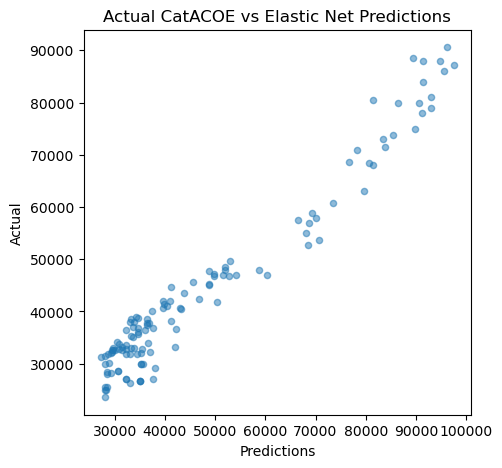

In [8]:
print('\nTrain set:')
pred_train_er = er.predict(X_train.loc[:, t])
print('RMSE =', np.sqrt(mean_squared_error(y_train, pred_train_er)))
print('MAE =', mean_absolute_error(y_train, pred_train_er))

print('\nTest set:')
pred_test_er = er.predict(X_test.loc[:, t])
print('RMSE =', np.sqrt(mean_squared_error(y_test, pred_test_er)))
print('MAE =', mean_absolute_error(y_test, pred_test_er))

df0 = pd.concat([y_test, pd.Series(pred_test_er, index=y_test.index)],
                axis=1).rename(columns={0:'y_pred'})
set_figsize(5, 5)
plt.scatter(x=df0.y_pred, y=df0.CatACOE, s=20, alpha=0.5)
plt.title(f'Actual CatACOE vs Elastic Net Predictions')
plt.xlabel('Predictions')
plt.ylabel('Actual')

header('\nAccuracy between Predictions vs Actual')
print(f'Correlation: {df0.CatACOE.corr(df0.y_pred)}')
print(f'R-Squared: {r2_score(df0.CatACOE, df0.y_pred)}')

# Time Series Decomposition
<a id='7'/>

The classical Time-Series decomposition is one of the many statistical methods to model time series data as a function of its Trend, Seasonality, and Noise. As its name suggests, decomposing the data into 3 main components makes it much easier to analyse the movement of COE prices over time. We chose this model to further study underlying patterns or seasonal changes in the data over the past years. There are 2 main models in decomposition, and their algorithms are given by:

$$Y_t^{Additive} = {S_t} + {T_t} + {R_t}$$
$$Y_t^{Multiplicative} = {S_t} \times {T_t} \times {R_t}$$

where $S =$ Seasonality, $T =$ Trend, $R =$ Residual. In these models, the idea is to breakdown the historical data and obtain each component:
> - Compute ${T_t}$ by using a smoothing method such as Moving-Averages, a simple algorithm can be expressed as:
$${T_t}={\frac{1}{m}}{\sum_{i=-k}^k}{y_{t+i}}$$ 
where ${m = 2k + 1}$ and ${k}$ indicates the window-period of ${t}$.
> - Detrend the observations ${Y_t}$ such that an estimate of the seasonality ${S_t}^{'} = {Y_t} - {T_t}$ for the Additive model, and ${S_t}^{'} = \frac{Y_t}{T_t}$ for the Multiplicative model;
> - Estimate of the residuals can be calculated by ${R_t}^{'} = {Y_t} - {T_t} - {S_t}^{'}$ for the Additive model, and ${R_t}^{'} = \frac{Y_t}{{T_t}\times{{S_t}^{'}}}$ for the Multiplicative model.

We first split the data into training and testing sets, with $p = 0.75$:

In [9]:
dt = df_ts[[target]]
_, _, y_train, y_test = split_train_test(dt, target, 0.25)


train set: (375, 1)
test set: (125, 1)


Then we define a series of helper functions to model the data using the naive _statsmodels.seasonal_decompose_ algorithm:

In [10]:
# Function to construct results df of decomposition and plot fit:
def decomposition_forecasts(y, per, ext, show_decomp, show_fit):
    if 'fitm' in vars():
        del fitm
    if 'rmsem' in vars():
        del rmsem
    if (dt[target] <= 0).any():
        print("\nNo 'Multiplicative' Decomposition since '" + y_train.name +
              "' has at least 1 non-positive value.") # not scale-invariant
    else:
        # multiplicative decomposition
        fitm, rmsem, forecast_rmsem = ynf('Multiplicative', y, per, ext, showdecomp=show_decomp, showfit=show_fit)

    # additive decomposition
    fita, rmsea, forecast_rmsea = ynf('Additive', y, per, ext, showdecomp=show_decomp, showfit=show_fit)

    # best weighted decompositions
    fito, rmseo, forecast_rmseo = ynf('Weighted', y, per, ext, fitm, fita, showdecomp=show_decomp, showfit=show_fit)

    forecasts = pd.DataFrame([
        [f'Additive Decomposition (Periodicity {per})', fita, rmsea, forecast_rmsea], 
        [f'Multiplicative-Additive Best-Weighted Decomposition (Periodicity {per})', fito, rmseo, forecast_rmseo]
                              ], columns=forecast_columns)
    if 'fitm' in vars():
        forecastm = pd.DataFrame([[f'Multiplicative Decomposition (Periodicity {per})', fitm, rmsem, forecast_rmsem]],
                                 columns=forecast_columns)
        forecasts = pd.concat([forecasts, forecastm])
        
    return forecasts

# Function to decompose, and plot fit:
def ynf(decomp, y, per, ext, fitm=[], fita=[], showdecomp=True, showfit=True):

    set_figsize(18, 8)
    plt.rcParams['lines.markersize'] = 1
    
    if decomp == 'Weighted':
        def f(w):
            # rmse of weighted multiplicative & additive fits (to minimise this cost)
            return sum((y - (w * fitm[:-ext] + (1 - w) * fita[:-ext]))**2)

        w = minimize(f, .5) # initial parameter = 0.5, to minimise cost towards global minimum
        rmseo = (w.fun / len(y))**.5 # .fun returns the minimum cost
        w = w.x[0] # .x returns the optimal w that minimises the cost
        fit = w * fitm + (1 - w) * fita
    
    else:
        try:
            mf4 = seasonal_decompose(y, model='mul' if decomp == 'Multiplicative' else 'add',
                                 period=per, extrapolate_trend=per) #scale-invariant for 'add'
        except:
            mf4 = seasonal_decompose(y, model='mul' if decomp == 'Multiplicative' else 'add',
                                 freq=per, extrapolate_trend=per)

        #plot y and forecast:

        yt0 = mf4.trend
        #append nans at trend's end:
        t = pd.concat([yt0, pd.Series(float('nan') * ext, index=pd.date_range(y.index[-1], periods=ext+1, freq=y.index.freq)[1:], name=yt0.name)])
        
        #extrapolate trend (weightage thru trial-&-error):
        t = pd.concat([yt0, (
            t.interpolate(method='spline', order=1, limit_direction='forward', limit_area='outside')[-ext:] * 19
            + t.interpolate(method='spline', order=2, limit_direction='forward', limit_area='outside')[-ext:]
            ) / 20])
        
        #extrapolate seasonal:
        ext2 = round(per * ceil(ext / per), 0) #ext rounded up to multiples of per
        s = pd.concat([mf4.seasonal, pd.Series(mf4.seasonal[-ext2:].to_numpy(), index=mf4.seasonal[-ext2:].index.shift(ext2))]).iloc[:len(t)]

        fit = t * s if decomp == 'Multiplicative' else t + s
    
    if showdecomp:
        mf4.plot()
    if showfit:
        plot_fit(0, fit, y, per, ext, decomp)
    
    fit_rmse = (((y - fit[:-ext])**2).mean())**.5
    forecast_rmse = (((y_test - fit[-ext:])**2).mean())**.5

    set_figsize()
    
    return fit, fit_rmse, forecast_rmse

# Function to plot fits:
def plot_fit(i, fit, y, per, ext, method): 

    # plot train, test, fit:
    ax[i].plot(y, color='red',  linewidth=.5, label='Train', linestyle='--')
    ax[i].plot(pd.concat([y[[y.last_valid_index()]], y_test]), color='orange', linewidth=.5, label='Test', linestyle='--')
    ax[i].plot(fit, linewidth=.8, label=method)
    line_date = y.last_valid_index()
    ax[i].axvline(x=line_date, color='grey', linestyle='--')
    ax[i].legend(loc='upper left')

    # to plot last 24 fitted & forecast values:
    # if len(y) > 5 * per:
    #     ax[i].plot(y[-2*per:], color='red',  linewidth=.5, label='Train')
    #     ax[i].plot(pd.concat([y[[y.last_valid_index()]], y_test]), color='orange', linewidth=.5, label='Test')
    #     ax[i].plot(fit[-2*per-ext:], linewidth=.5, label=method)
    #     line_date = y.last_valid_index()
    #     ax[i].axvline(x=line_date, color='grey', linestyle='--')


# Training The Decomposition Model
<a id='8'/>

The hyperparameters being tested here are the periodicity and 3 decomposition methods. We tested a range of periods for the model to try $\in \begin{Bmatrix} 12, 24, 36, 48, 60 \end{Bmatrix}$. For each period group, we then tested across the 3 decomposition techniques, with the weighted combination having a configuration of weights assigned to both Additive and Multiplicative fits. The weights are determined using the _scipy.optimise.minimise()_ algorithm, which aims to minimise the cost (in this case ${RMSE}$) of the training set and predicted values. The solution fit of the weighted model can be expressed as:

$$
    {Y_t}^{'} = \omega{Y_t}^{mul} + {(1-\omega)}{Y_t}^{add}
$$

where $\omega =$ optimal weight parameter based on minimisation problem. This parameter will change with a new combination of period and method being tested as the fits and respective cost functions will. The result was a $({5}\times{3})$ fit matrix, for 5 different periods across 3 different methods. No ${k}$-fold cross-validation was performed here due to the limitation of the time series model.

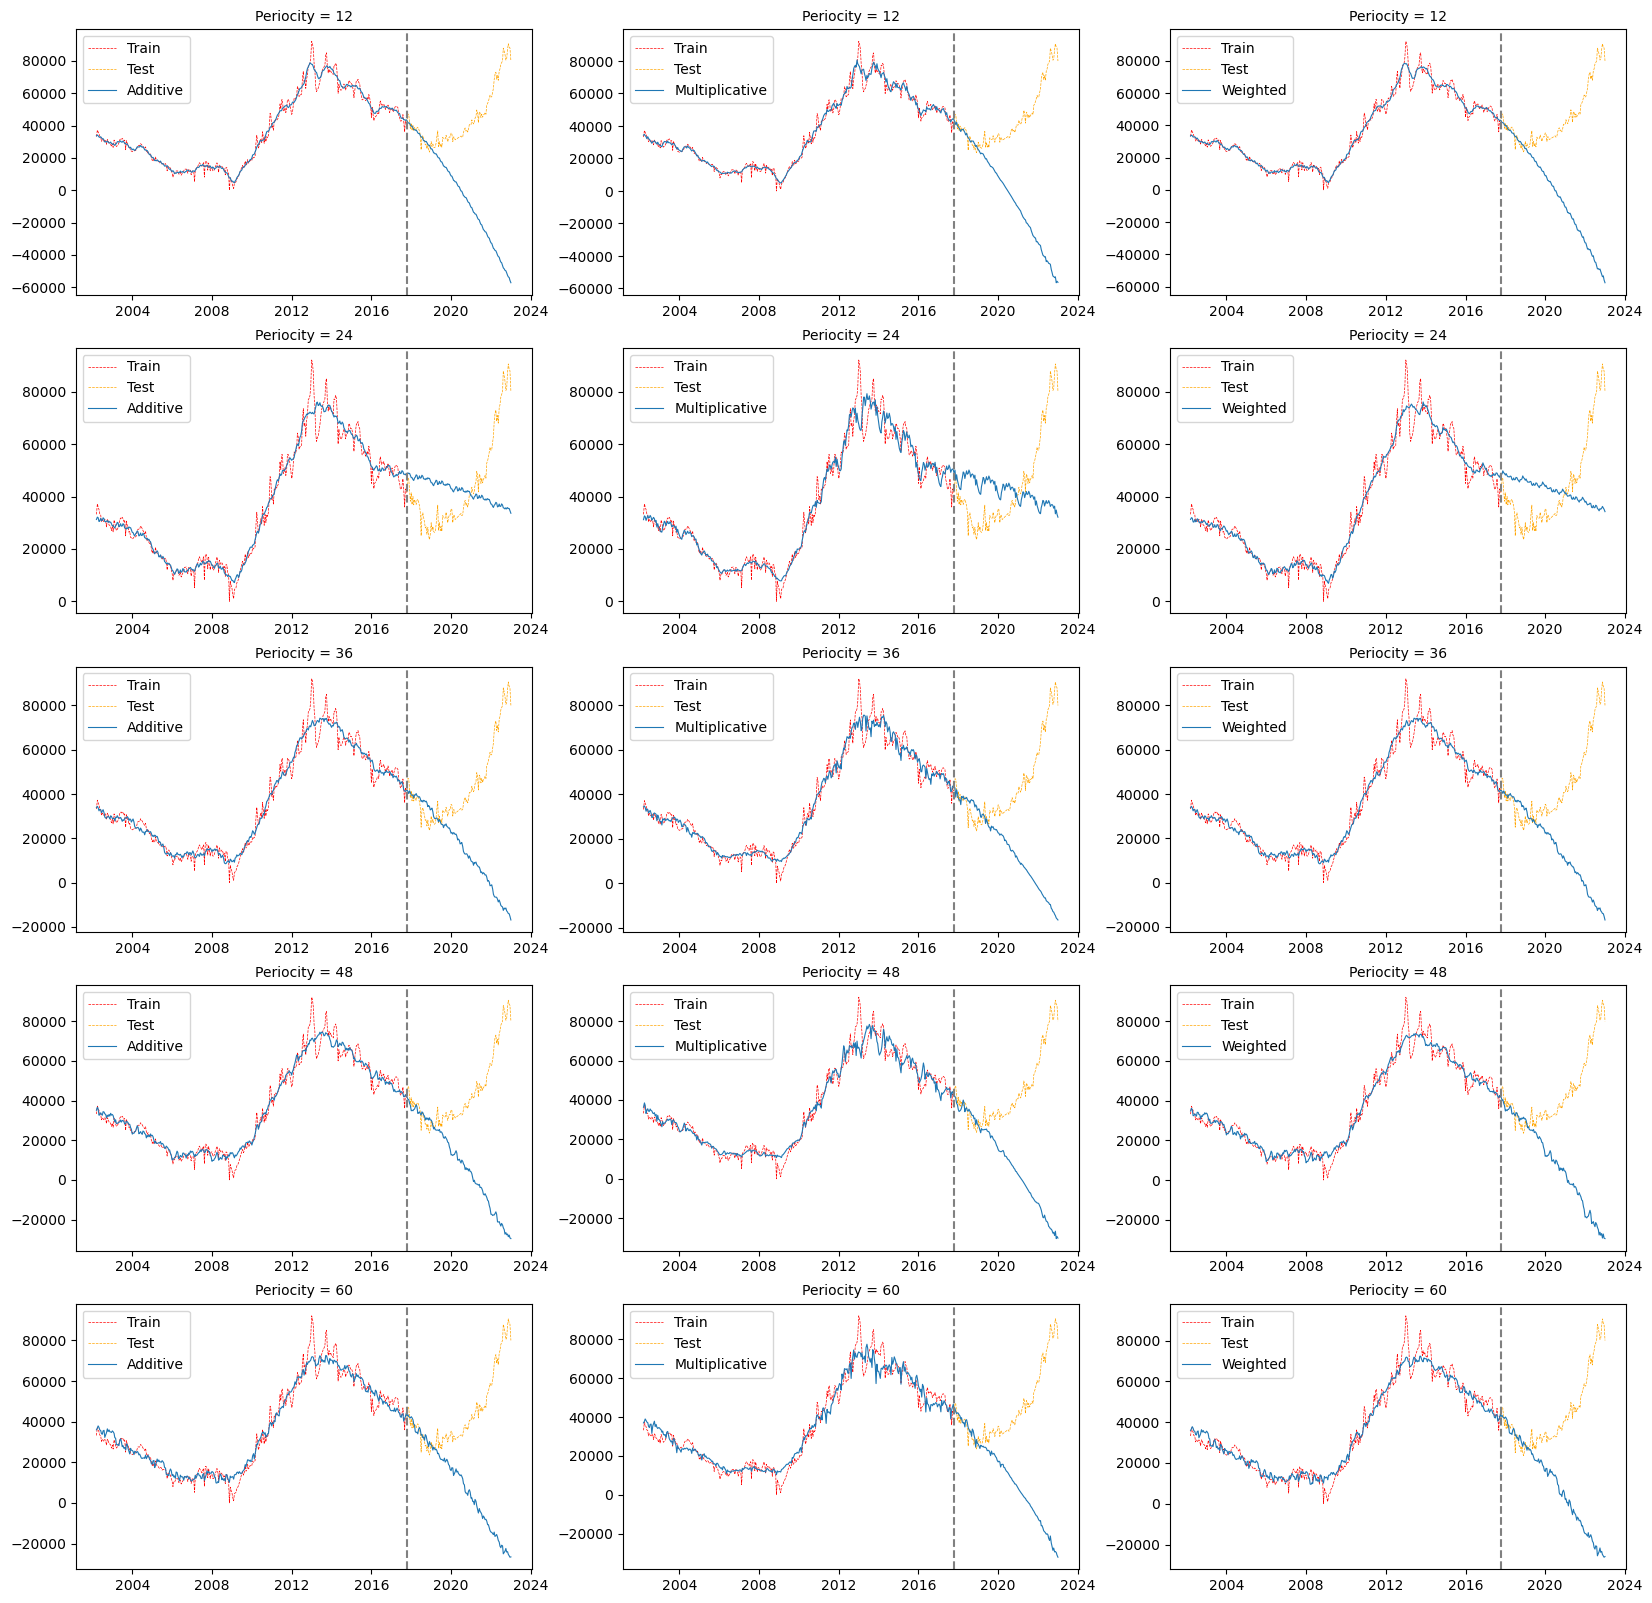

,Fit,Forecast,Fit_RMSE,Forecast_RMSE
0,Additive Decomposition (Periodicity 12),"2002-03-15 33631.777622 2002-04-01 34158.867165 2002-04-15 33671.439781 2002-05-01 32910.725272 2002-05-15 32679.396503 ... 2022-11-01 -52692.758862 2022-11-15 -53610.715266 2022-12-01 -54073.231299 2022-12-15 -55792.667764 2023-01-01 -57247.187826 Freq: SMS-15, Length: 500, dtype: float64",2966.185259,64324.769700
1,Multiplicative-Additive Best-Weighted Decomposition (Periodicity 12),"2002-03-15 33398.694108 2002-04-01 33944.040330 2002-04-15 33551.678521 2002-05-01 32753.026304 2002-05-15 32831.020180 ... 2022-11-01 -52492.562645 2022-11-15 -53858.470423 2022-12-01 -53309.907601 2022-12-15 -55865.992002 2023-01-01 -57572.617756 Freq: SMS-15, Length: 500, dtype: float64",2954.742424,64315.482152
0,Multiplicative Decomposition (Periodicity 12),"2002-03-15 34363.110064 2002-04-01 34832.916697 2002-04-15 34047.207648 2002-05-01 33405.528056 2002-05-15 32203.655802 ... 2022-11-01 -53320.902768 2022-11-15 -52833.348472 2022-12-01 -56468.267204 2022-12-15 -55562.602614 2023-01-01 -56226.105459 Freq: SMS-15, Length: 500, dtype: float64",3144.904777,64360.531317
0,Additive Decomposition (Periodicity 24),"2002-03-15 31247.494022 2002-04-01 32130.294903 2002-04-15 31918.140055 2002-05-01 30475.624799 2002-05-15 30686.380610 ... 2022-11-01 35773.610773 2022-11-15 35406.226052 2022-12-01 35412.641684 2022-12-15 34578.928760 2023-01-01 33611.289410 Freq: SMS-15, Length: 500, dtype: float64",3865.568241,21387.064764
1,Multiplicative-Additive Best-Weighted Decomposition (Periodicity 24),"2002-03-15 31277.369729 2002-04-01 31927.843932 2002-04-15 31750.017310 2002-05-01 30309.571436 2002-05-15 30244.128760 ... 2022-11-01 35553.192478 2022-11-15 36226.141317 2022-12-01 35651.729609 2022-12-15 35129.515294 2023-01-01 34228.018916 Freq: SMS-15, Length: 500, dtype: float64",3798.194370,21402.677066
0,Multiplicative Decomposition (Periodicity 24),"2002-03-15 31174.733796 2002-04-01 32623.350278 2002-04-15 32327.591403 2002-05-01 30880.036309 2002-05-15 31763.454483 ... 2022-11-01 36310.424326 2022-11-15 33409.378989 2022-12-01 34830.359536 2022-12-15 33238.013239 2023-01-01 32109.287245 Freq: SMS-15, Length: 500, dtype: float64",4529.921718,21439.756892
0,Additive Decomposition (Periodicity 36),"2002-03-15 33834.372241 2002-04-01 34376.859208 2002-04-15 33808.500215 2002-05-01 32371.878596 2002-05-15 33099.708997 ... 2022-11-01 -13311.396154 2022-11-15 -13988.610733 2022-12-01 -14089.286707 2022-12-15 -15230.861681 2023-01-01 -16892.339408 Freq: SMS-15, Length: 500, dtype: float64",3950.184270,43866.373934
1,Multiplicative-Additive Best-Weighted Decomposition (Periodicity 36),"2002-03-15 33821.219478 2002-04-01 34368.507590 2002-04-15 33801.635400 2002-05-01 32370.469018 2002-05-15 33089.826267 ... 2022-11-01 -13296.521773 2022-11-15 -13975.523002 2022-12-01 -14053.299533 2022-12-15 -15212.963695 2023-01-01 -16901.662017 Freq: SMS-15, Length: 500, dtype: float64",3950.054364,43869.497541
0,Multiplicative Decomposition (Periodicity 36),"2002-03-15 34388.503284 2002-04-01 34728.716142 2002-04-15 34097.717545 2002-05-01 32431.264694 2002-05-15 33516.072286 ... 2022-11-01 -13938.059631 2022-11-15 -14540.001955 2022-12-01 -15605.440451 2022-12-15 -15984.910809 2023-01-01 -16499.574231 Freq: SMS-15, Length: 500, dtype: float64",4184.740886,43746.581919
0,Additive Decomposition (Periodicity 48),"2002-03-15 35090.982140 2002-04-01 36619.059998 2002-04-15 35782.101397 2002-05-01 32566.403214 2002-05-15 32921.194614 ... 2022-11-01 -27327.399674 2022-11-15 -28670.972491 2022-12-01 -27841.454617 2022-12-15 -29259.926041 2023-01-01 -29614.253895 Freq: SMS-15, Length: 500, dtype: float64",4238.390796,51632.061442


In [11]:
forecasts = pd.DataFrame()
forecast_columns = ['Fit', 'Forecast', 'Fit_RMSE', 'Forecast_RMSE']
ext = y_test.shape[0]

# range of periods to try
period_vec = range(12, 72, 12)
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
ax = np.ravel(ax)
decomps = ['Additive', 'Multiplicative', 'Weighted']
count = 0

for per in period_vec:
    forecasts = pd.concat([forecasts, decomposition_forecasts(y_train, per, ext, show_decomp=False, show_fit=False)])
    for m in decomps:
        if m == 'Weighted':
            fita = ynf('Additive', y_train, per, ext, showdecomp=False, showfit=False)[0]
            fitm = ynf('Multiplicative', y_train, per, ext, showdecomp=False, showfit=False)[0]
            fit = ynf('Weighted', y_train, per, ext, fitm, fita, showdecomp=False, showfit=False)[0]
        else:
            fit = ynf(m, y_train, per, ext, showdecomp=False, showfit=False)[0]
        
        plot_fit(count, fit, y_train, per, ext, m)
        ax[count].set_title(f"Periocity = {per}", fontsize=10)
        count += 1
        
plt.show()
display(forecasts)

## Results
<a id='9'/>

We obtained the optimal model hyperparameters based on the lowest test error which resulted in an Additive Decomposition model with Periodicity ${= 24}$, yielding ${RMSE} = 21387.06$ score. From the plots above, we noticed the decomposition algorithm was only able to forecast values accurately until about 2019, before the errors become incredibly large for all cases. In the plot below displaying the optimal fit, analysing the shape of the line can indicate the following:
> - the shape tends to model the mean of the test data, hence minimising error compared to other models which predicted extreme values too far off from 2019 onwards;
> - the model may be generalised (i.e too simple) which may suggest some form of underfitting;
> - the trend did not seem to be extrapolated well given its negative gradient compared to that of the test data.

Best Time-Series Model, Lowest Error: 


,Fit,Forecast_RMSE
0,Additive Decomposition (Periodicity 24),21387.064764


RMSE Test = 21387.06476411315
MAE Test = 16656.814589635887


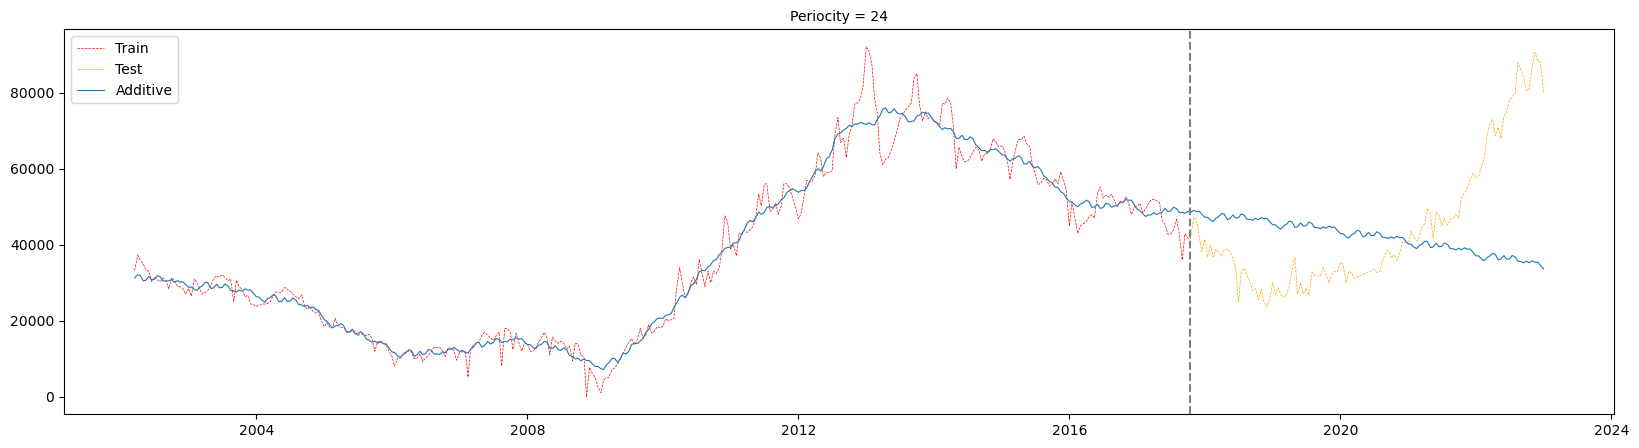

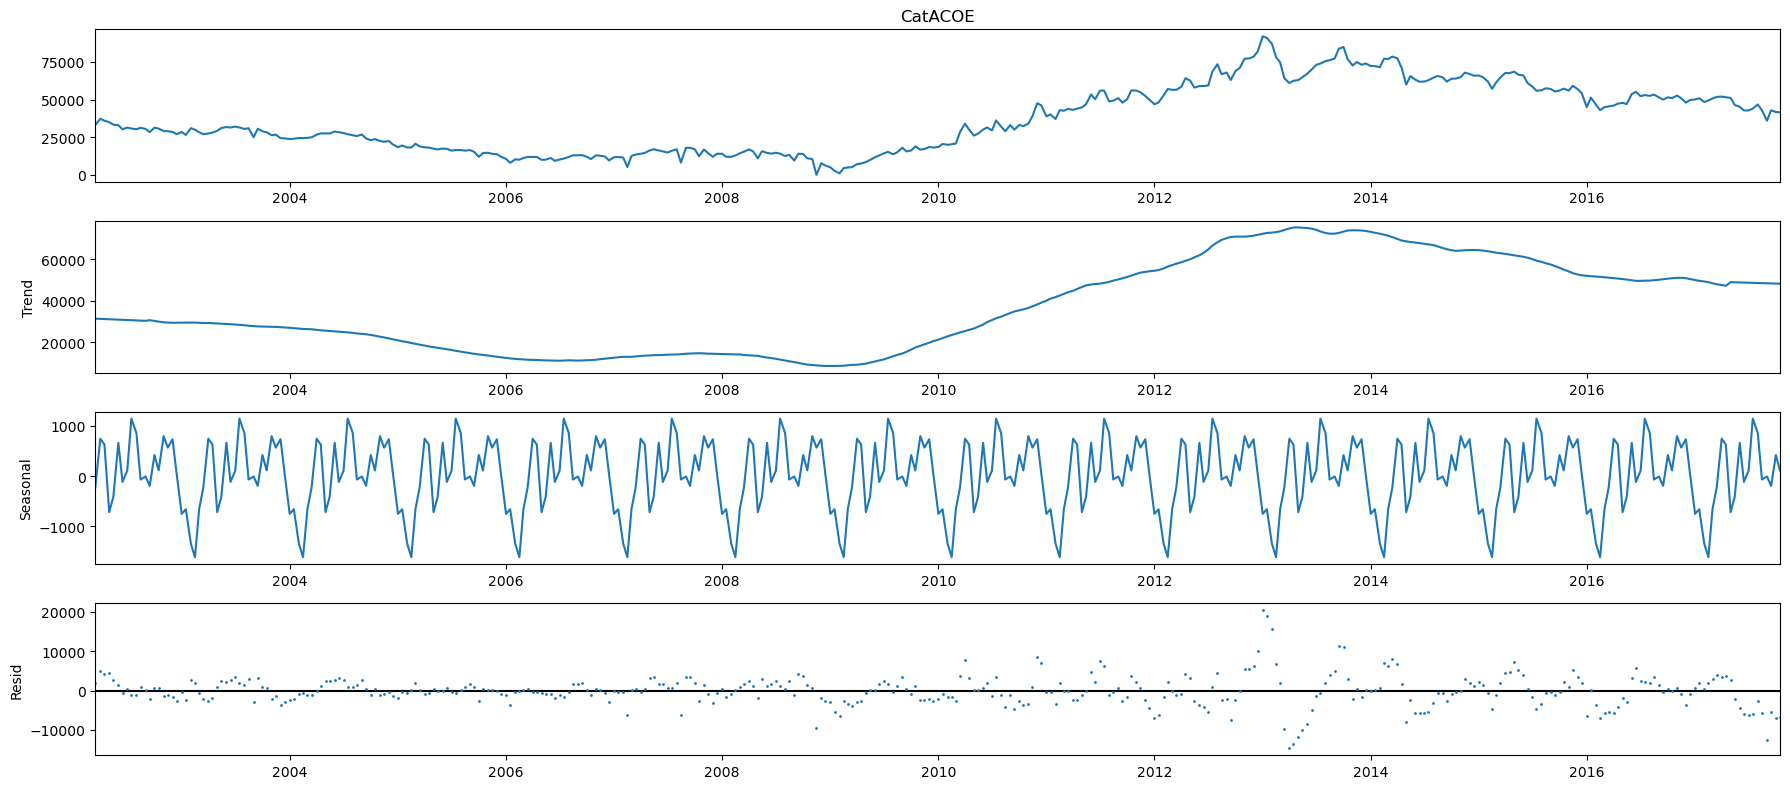

In [12]:
header('Best Time-Series Model, Lowest Error: ')
bestts = forecasts[forecasts.Forecast_RMSE == min(forecasts.Forecast_RMSE)]
display(bestts[['Fit', 'Forecast_RMSE']])

print('RMSE Test =', bestts.Forecast_RMSE[0])
print('MAE Test =', mean_absolute_error(y_test, bestts.Forecast[0][-ext:]))

# extract best periodicity:
import regex as re
pattern = r"\((.*?)\)"
match = re.search(pattern, bestts.Fit[0])
bestper = int(match.group(1)[-2:])

# extract best method:
bestmethod = bestts.Fit[0].split(' ')
bestmethod = bestmethod[0]

del fig, ax 
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax = np.ravel(ax)
ynf(bestmethod, y_train, bestper, ext, showdecomp=True, showfit=True)
ax[0].set_title(f"Periocity = {bestper}", fontsize=10)
plt.show()

# Regression vs Decomposition Results
<a id='10'/>

We plotted the 2 forecasting supervised-learning methods against the test data and observed a stark difference in predictions. The Elastic Net Regression model seemed to capture the trend and seasonality of the test data well while the decomposition forecast was not as accurate. We hypothesise that these results show the significance of the regularisation parameters that are not present in the Time Series model, which may have affected how the model was trained and performed on unseen data.

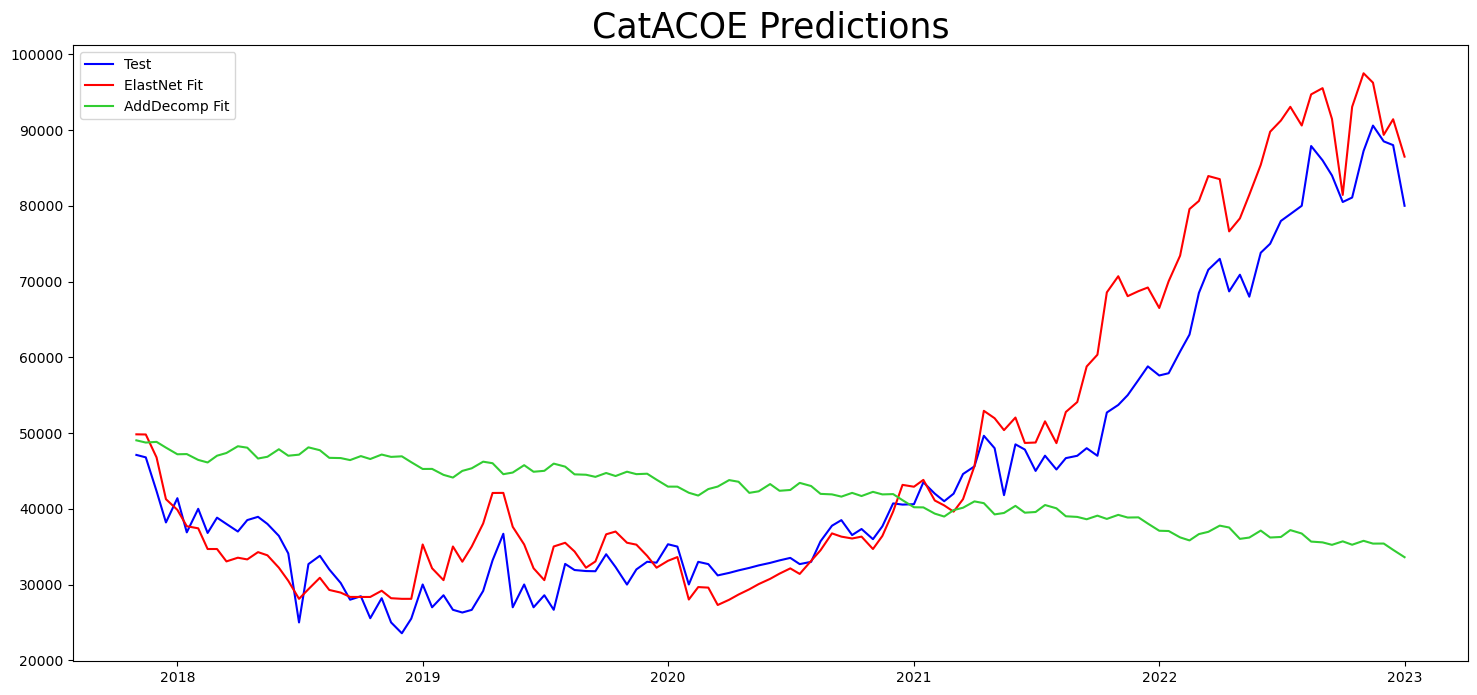

In [13]:
set_figsize(18,8)
plt.plot(y_test, color='blue', label='Test')
plt.plot(pd.Series(er.predict(X_test.loc[:, t]), index=y_test.index), 
         color='red', label='ElastNet Fit')
plt.plot(bestts.Forecast[0][-ext:], color='limegreen', label = 'AddDecomp Fit')
plt.legend()
plt.title('CatACOE Predictions', size=25)
plt.show()
set_figsize()

# KNN Classification
<a id='11'/>

The K-Nearest Neighbour Classification is a non-parametric, supervised machine-learning technique that models the class of a new data point depending on the numerical distance from its ${1_{st}...k_{th}}$ neighbours. In the context of our dataset, we engineered a new target feature `CatACOEChange` which has 3 classes indiciating if `CatACOE` increased, decreased or had no change from the previous bidding round. There are several distance measures for the independent features in this model. Let ${P}, {Q}$ be 2 data points with ${k}$ features such that:

> - Euclidean's Distance:
$$D_{L_2}{(P, Q)} = \sqrt{\sum_{i=1}^k{(P_i - Q_i)^2}}$$
> - Mahalanobis Distance:
$$D_{M}{(P, Q)} = \sqrt{{(\vec{P} - \vec{Q})^{T}{C^{-1}}{(\vec{P} - \vec{Q})}}}$$ 
where ${T} =$ transposition of column vector of features ${(\vec{P} - \vec{Q})}$:
$
\begin{bmatrix}
P_1 - Q_1 \\
P_2  - Q_2 \\
\vdots \\
P_k - Q_k
\end{bmatrix} \
$

and ${C} =$ covariance matrix:
$
\begin{bmatrix}
\sigma_1^{2} & \sigma_{1,2}^{2} & \cdots & \sigma_{1,k}^{2} \\
\sigma_{2,1}^{2}& \sigma_2^{2} & \cdots & \sigma_{2,k}^{2} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{k,1}^{2} & \sigma_{k,2}^{2} & \cdots & \sigma_k^{2}
\end{bmatrix} \
$
> - Manhattan's Distance:
$$D_{L_1}{(P, Q)} = {\sum_{i=1}^k{|P_i - Q_i|}}$$

In K-Nearest Neighbours problems, the issue of scaling is important as it directly impacts the distances between 2 points. The Euclidean and Manhattan distance measures are naive as they calculate absolute differences between the vectors of 2 points. In some sense, the Mahalanobis measure is similar to Euclidean, but the main difference is the incorporation of variances across independent features. This approach makes the algorithm more normalised which takes into account scale and collinearity as well.

We prepare the dataset for training by:
> - adding the new target feature `CatACOEChange`;
> - dropping the first row because it is not possible to predict a change from the first observation of the dataset.

The final dataset is given by a $498 \times 13$ matrix, with a proportion of class $Increase = 52.2\%$, $Decrease= 47.4\%$, and $No\_Change = 4.0\%$.

In [14]:
target_class = 'CatACOEChange'
df_class[target_class] = np.nan

# engineer new column:
for i in range(1, len(df_class)):
    if pd.isna(df_class[target][i]) or pd.isna(df_class[target][i - 1]): 
        # if the current or previous value == NA, then cannot calculate difference
        df_class[target_class][i] = np.nan
    else:
        diff = df_class[target][i] - df_class[target][i-1]
        df_class.loc[df_class.index[i], target_class] = 'increase' if diff > 0 else (
            'no-change' if diff == 0 else 'decrease')

df_class = df_class.dropna(subset=target_class) # drop rows with missing 'CatACOEChange'
display(df_class.head())
print(df_class.shape)
print(df_class.CatACOEChange.value_counts(), '\n')

,CatACOE,CatAQuota,CatABids,CatBCOE,CatBQuota,CatBBids,CatECOE,CatEQuota,CatEBids,A_bids/Quota,B_bids/Quota,E_bids/Quota,CatACOEChange
Date,,,,,,,,,,,,,
2002-04-01,37201.0,1110.0,2484.0,39509.0,558.0,1119.0,41001.0,682.0,1797.0,2.237838,2.005376,2.634897,increase
2002-04-15,36000.0,1149.0,1890.0,42101.0,553.0,1104.0,42043.0,754.0,1407.0,1.644909,1.996383,1.866048,decrease
2002-05-01,35000.0,1128.0,1705.0,40001.0,560.0,1043.0,40001.0,960.0,1880.0,1.511525,1.862500,1.958333,decrease
2002-05-15,33401.0,1111.0,1320.0,38001.0,552.0,894.0,38399.0,910.0,1835.0,1.188119,1.619565,2.016484,decrease
2002-06-01,33009.0,1111.0,1382.0,33001.0,595.0,885.0,34397.0,939.0,1777.0,1.243924,1.487395,1.892439,decrease


(498, 13)
increase     260
decrease     236
no-change      2
Name: CatACOEChange, dtype: int64 



Similarly, we split the data with $p = 0.75$;

In [15]:
X_train, X_test, y_train, y_test = split_train_test(df_class, target_class, 0.25)


train set: (374, 13)
test set: (124, 13)


## Training The Classification Model
<a id='12'/>

We define a scaling function and classification function to perform the model-training, using the _KNeighborsClassifier_ algorithm and scalers from scikit-learn:

In [16]:
def scale(scaling, data):
    scaler = StandardScaler() if scaling == 'Standard' else (
        RobustScaler() if scaling == 'Robust' else MinMaxScaler()
    )
    
    scaled = scaler.fit_transform(data)
    scaled = pd.DataFrame(scaled, columns = data.columns, index = data.index)

    return scaled


def classify(distance, scaletype, trainx, neighbors, cv = True):
    
    # scale:
    scale_trainx = scale(scaletype, trainx)
        
    # apply distance measures:
    if distance == 'Mahalanobis':
        #https://datascience.stackexchange.com/questions/113758/knn-using-mahalanobis-distance-gives-low-score
        knn = KNeighborsClassifier(neighbors, weights='distance', metric='mahalanobis', 
                                    metric_params={'VI': np.cov(np.linalg.inv(np.cov(scale_trainx.T)), rowvar=False)
                        })
    elif distance == 'Manhattan':
        knn = KNeighborsClassifier(neighbors, weights='distance', metric='manhattan')
    elif distance == 'Euclidean':
        knn = KNeighborsClassifier(neighbors, weights='distance')

    if cv:
        scores = cross_val_score(estimator = knn, X = scale_trainx, y = y_train, cv = k_fold, \
                                 scoring = 'accuracy', n_jobs = -1)
        return scores.mean()
    else:
        knn.fit(scale_trainx, y_train)
        return knn

The hyperparameters tested here are the feature-scaling and distance measures as both play significant roles in determining the neighbours of a new data point. We also tested against the number of neighbors as a practical alternative for the elbow method, with a range of ${k} \in \begin{Bmatrix} 5, 10, 15 ... 336\end{Bmatrix}$. Because each validation fold is ${10\%}$, the maximum number of neighbors we can have is approximately ${90\%}$ of the length of the training data, which indicates every row as a neighbor.

We first tried 3 different normalisation methods which are given by:

> - Gaussian Standard: 
$$\frac{x - \mu}{\sigma}$$
> - Robust: 
$$\frac{x - x_{median}}{IQR}$$
> - Min-Max: 
$${\frac{x - x_{min}}{x_{max} - x_{min}}}{(1 - 0)} + 0$$

Each scaling method is used for each distance measure, against each ${k}$-value. To train the model, we ran a total of 603 combinations of these hyperparameters, with each combination being cross-validated across 10 folds, yielding an average accuracy score per 10-fold. Sorting by highest accuracy score, we obtained the optimal hyperparameters with Euclidean distance, Robust Scaler and ${k}$ = 55.


In [17]:
scales = ['Standard', 'Robust', 'Min-Max']
measures = ['Euclidean', 'Manhattan', 'Mahalanobis']

class_scores = pd.DataFrame(
    columns=['Distance_Metric', 'Scaler', 'K', 'CV_Accuracy']
    )

k_vec = range(5, floor(len(X_train) * (1 - 1/k_fold)), 5)

# training:
for k in k_vec:
    for i in measures:
        for j in scales:
            row = [i, j, k, classify(i, j, X_train, k)]
            row = pd.Series(row, index=class_scores.columns)
            class_scores = class_scores.append(row, ignore_index=True)

# return dataframe results:
class_scores = class_scores.sort_values('CV_Accuracy', ascending=False)
display(class_scores)

header('Best-Performing Model Based on Highest CV-Accuracy: ')
class_best = class_scores.iloc[class_scores.CV_Accuracy.argmax()]
print(f'Optimal params:\n{class_best}')

,Distance_Metric,Scaler,K,CV_Accuracy
91,Euclidean,Robust,55,0.603556
109,Euclidean,Robust,65,0.598222
100,Euclidean,Robust,60,0.598080
136,Euclidean,Robust,80,0.592959
118,Euclidean,Robust,70,0.592959
...,...,...,...,...
23,Manhattan,Min-Max,15,0.470341
2,Euclidean,Min-Max,5,0.469915
41,Manhattan,Min-Max,25,0.467283
14,Manhattan,Min-Max,10,0.454694


Best-Performing Model Based on Highest CV-Accuracy: 
Optimal params:
Distance_Metric    Euclidean
Scaler                Robust
K                         55
CV_Accuracy         0.603556
Name: 91, dtype: object


## Results
<a id='13'/>

In Classification problems, we can evaluate prediction accuracy of a model using the Classification Report. Its components are computed from True Negatives (TN), True Positives (TP), False Negatives (FN), False Positives (FP). Click [here](https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397) to know more about how these interpretations work. They can also be visualised through a confusion matrix where it can mathematically described as:

$$
\begin{bmatrix}
TP & FN \\ FP & TN \\
\end{bmatrix} \
$$

where the rows represent the classes of the actual values, and the columns represent the classes of the predictions. The formulas and definitions for each component are given below (in the context of our model):
> - Precision: among the predictions of class $k$, how many were actually correctly predicted?
$$ Precision = \frac{TP}{TP + FP} $$

> - Recall: among the true values of each class $k$, how many were actually correctly predicted?
$$ Recall = \frac{TP}{TP + FN} $$

> - F1-Score: a weighted average of both Precision & Recall (due to the Precision-Recall tradeoff)
$$ F1 = 2 \left(\frac{Recall \times Precision}{Recall + Precision}\right) $$

> - Accuracy: among all predictions, how many are actually correct?
$$ Accuracy = \frac{TP + TN}{TP + FP + TN + FN} $$
In a 3-Dimensional space, the confusion matrix would like something like:

$
\begin{bmatrix}
TP & FN & FN \\
FP & TN & TN \\
FP & TN & TN
\end{bmatrix} \
$
$
\begin{bmatrix}
TN & FP & TN \\
FN & TP & FN \\
TN & FP & TN
\end{bmatrix} \
$
$
\begin{bmatrix}
TN & TN & FP \\
TN & TN & FP \\
FN & FN & TP
\end{bmatrix} \
$

We refit the optimal hyperparameters into the model and ran it against the test data, obtaining a test accuracy $= 71.8\%$. We also achieved F1-Scores for class $Increase = 76\%$ and that of class $Decrease = 66\%$, which is generally acceptable.


Test set:
Accuracy = 0.717741935483871


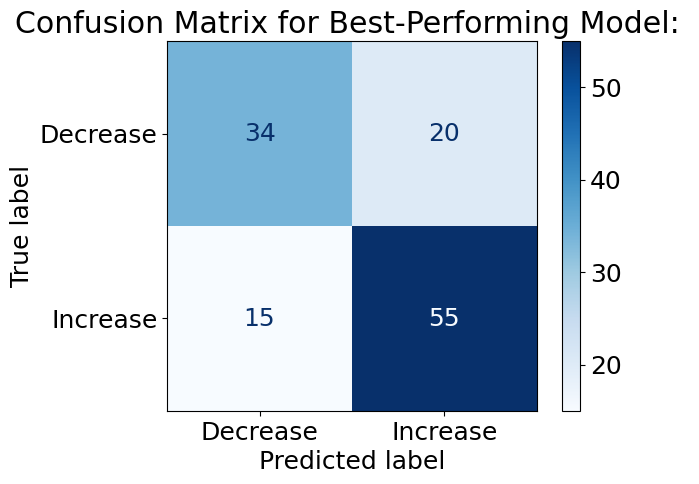

Classification Report: 



{'TP': array([34, 55]),
 'FN': array([20, 15]),
 'FP': array([15, 20]),
 'TN': array([55, 34])}

              precision    recall  f1-score   support

    decrease       0.69      0.63      0.66        54
    increase       0.73      0.79      0.76        70

    accuracy                           0.72       124
   macro avg       0.71      0.71      0.71       124
weighted avg       0.72      0.72      0.72       124



In [18]:
knn = classify(class_best.Distance_Metric, class_best.Scaler, X_train, class_best.K, False)
print('\nTest set:')
scale_testx = scale(class_best.Scaler, X_test)
print('Accuracy =', knn.score(scale_testx, y_test))

# confusion matrix:
pred_test_class = knn.predict(scale_testx)
classes = np.union1d(np.unique(y_test), np.unique(pred_test_class)) # get all classes
class_labels = [x.capitalize().replace('-', ' ') for x in classes]

plt.rcParams.update({'font.size': 18})
cm = confusion_matrix(y_true=y_test, y_pred=pred_test_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best-Performing Model: ')
plt.show()

# classification report:
TP = np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
FP = cm.sum(axis=0) - np.diag(cm) 
TN = cm.sum() - (FP + FN + TP)
evals = [TP, FN, FP, TN]
header('Classification Report: \n')
i = 0
cmdict = {}
for n in ['TP', 'FN', 'FP', 'TN']:
    cmdict[n] = evals[i]
    i += 1
display(cmdict)
print(classification_report(y_test, pred_test_class))

# Conclusion
<a id='14'/>

Generally, the Elastic Net Regression model and Classification model managed to predict the test data relatively well. The Time Series Decomposition, although achieving the lowest test error among other models, did not perform as well as the Regression model. While attempting to match the mean to reduce overall error, the resulting model was also too simple to reflect the trend and seasonal cycles of the target feature. Instead, we recommend using Decomposition as a tool to capture underlying patterns in the data, while depending on a more regularised model to predict the numerical values. Graphically, we would expect the `CatACOE` prices to continue increasing based on historical trend as well. Based on the Regression model, we can express it as the following linear function:

$${COE_A} = 0.84\times{COE_B} + constant$$

which implies that every $\$10,000$ increase in Cat B COE premium would lead to an approximately $\$8,400$ increase in Cat A COE prices.

We also acknowledge some limitations of our analysis such as handling multicollinearity, limited data and other training methods. These include feature engineering the independent variables to higher-order polynomials which may affect the regression model and/or discover other significant statistics. Using the $RMSE$ metric to calculate accuracy across all models may also be too naive, and instead other scoring methods such as $AIC$, $BIC$, and $R^2$ may be more intuitive/holistic.

# References
<a id='15'/>

COE: https://onemotoring.lta.gov.sg/content/onemotoring/home/buying/upfront-vehicle-costs/certificate-of-entitlement--coe-.html

Time Series: https://otexts.com/fpp2/components.html

KNN Classification Report: https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397